In [27]:
import geopandas as gp
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.linear_model import LinearRegression
import contextily as ctx

import util

In [6]:
# Config and Setup
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","blue","purple"])

# Load Shapefile with City Data
- Data contains: 
    - name: city name
    - rent: median contract rent
    - price: median home value 
    - geometry: polygon used to plot shape of state
    - price_to_rent: calculated using by taking the quotient of median home value and twelve months of median rent 
    - population: total population
    - year: dataset year
    - state: state name
      

In [31]:
cities_gdf = gp.read_file("data/shapefiles/cities/price_to_rent_cities.shp")
# Calculate price to rent ratio column 
cities_gdf["price_to_rent"] = round(cities_gdf.MEDIAN_HOM/(cities_gdf.MEDIAN_CON*12),1)
# Remove Puerto Rico since analysis is only concerned with US states  
cities_gdf = cities_gdf[~cities_gdf['NAME'].str.contains("Puerto Rico")]
# Make column with state name by splitting city name
cities_gdf['state'] = cities_gdf.NAME.apply(lambda x:x.split(',')[1].strip())
# Convert city geometry into point (centroid)
cities_gdf['geometry'] = cities_gdf.geometry.centroid
# Rename columns to more readable names
cities_gdf = cities_gdf.rename(columns={
    "MEDIAN_CON":"rent", 
    "MEDIAN_HOM":"price", 
    "NAME":"name",
    "TOTAL_POPU":"population",
    "YEAR":"year",
    }
)
# Drop price to rent column that came with data-set since it's rounded to nearest integer, 
# we want 1 significant figure
cities_gdf.drop("PRICE_TO_R", axis=1, inplace=True)
# Save data as geojson for use with Chart.js graphs and maps
cities_gdf.to_file('geojson/cities.geojson', driver='GeoJSON')
# Set CRS to 3857
cities_gdf = cities_gdf.to_crs(epsg=3857)
cities_gdf.head()

,name,year,population,rent,price,geometry,price_to_rent,state
0,"New York, New York",2019,8398748,1337,645100,POINT (-8230780.524696544 4962890.010672231),40.2,New York
1,"Los Angeles, California",2019,3990469,1355,682400,POINT (-13181528.04187574 4043178.112958237),42.0,California
2,"Chicago, Illinois",2019,2705988,956,271600,POINT (-9761016.640787872 5136576.324973135),23.7,Illinois
3,"Houston, Texas",2019,2326090,895,179100,POINT (-10618799.0104465 3476181.308694161),16.7,Texas
4,"Phoenix, Arizona",2019,1660272,894,249100,POINT (-12477699.30139582 3971499.128698391),23.2,Arizona


# Create Linear Regression Model and Plot Scatter Chart
- Create linear regressor using sklearn LinearRegression
- Predict Y values for target column 
- Use scipy linregress to show slope, rvalue, pvalue and standard error
- Plot scatter plot and predicted Y values from linear regression model

In [17]:
 # create object for the class
linear_regressor = LinearRegression()
# perform linear regression
linear_regressor.fit(
    cities_gdf[['rent']],
    cities_gdf[['price_to_rent']]
)
# make predictions
Y_pred = linear_regressor.predict(cities_gdf[['rent']])

# Get r-value, p-value, and slope
linregress(cities_gdf['price_to_rent'], cities_gdf['price'])

LinregressResult(slope=26223.336925212057, intercept=-278124.38401484978, rvalue=0.90348440327696666, pvalue=3.8698275625022956e-120, stderr=694.36558924470239)

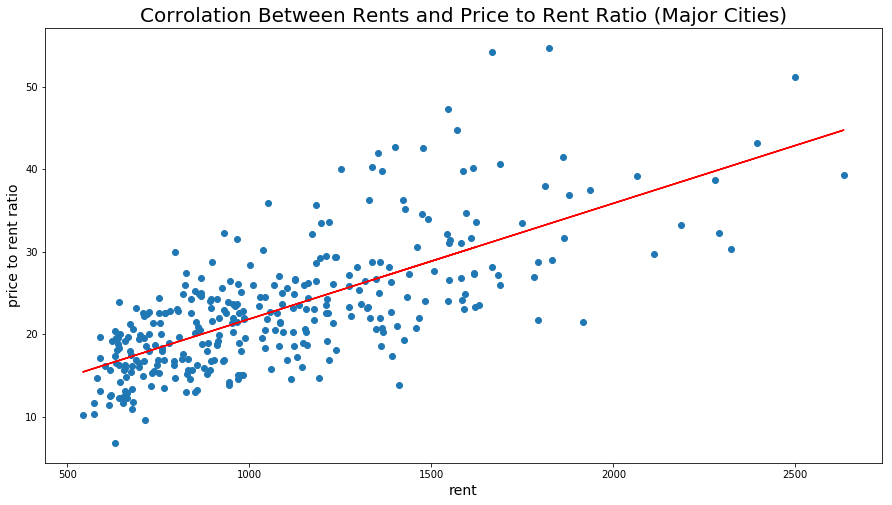

In [19]:
plt.figure(figsize=(15,8))

plt.scatter(
    cities_gdf["rent"], 
    cities_gdf["price_to_rent"],
)
plt.plot(
    cities_gdf[['rent']], 
    Y_pred, 
    color='red',
)

plt.xlabel('rent', fontsize=14)
plt.ylabel('price to rent ratio', fontsize=14)
plt.title('Corrolation Between Rents and Price to Rent Ratio (Major Cities)',  fontsize=20)

plt.show()

# Plot Map For Each City's Price to Rent Ratio 
- Add basemap from contextily library
- Plot colorbar using CMAP global defined in config step above
- Save image in /images directory

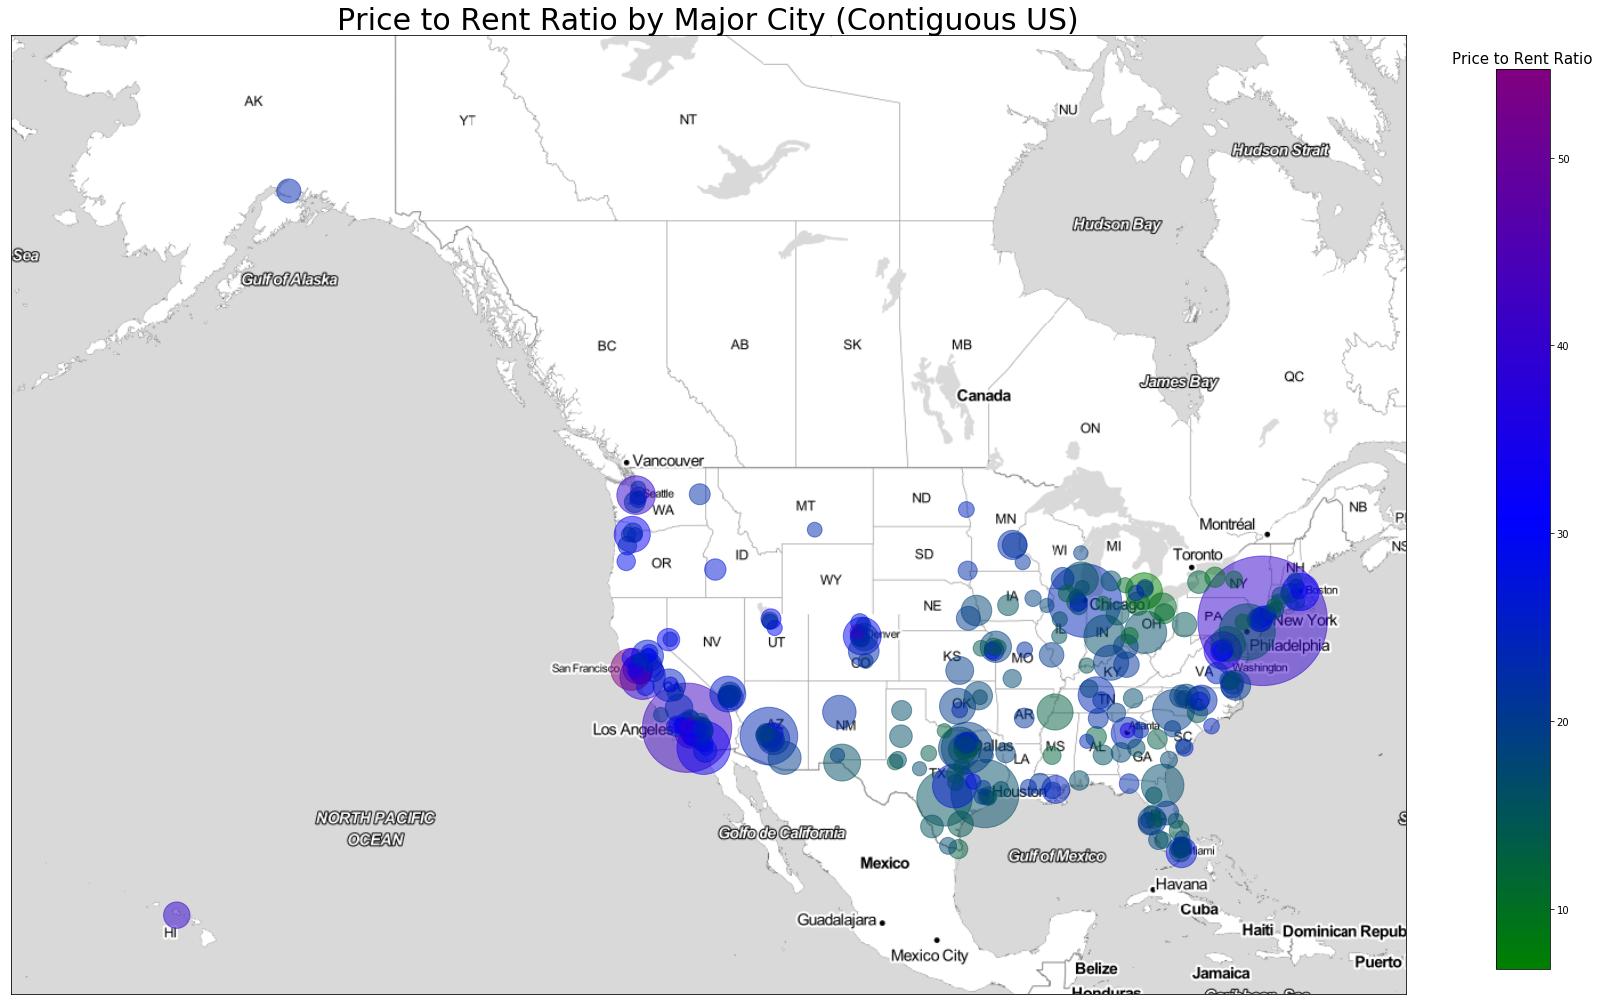

In [25]:
column = "price_to_rent"
title = "Price to Rent Ratio by Major City (Contiguous US)"
vmin = cities_gdf[column].min()
vmax = cities_gdf[column].max()

ax = cities_gdf.plot(
    column=column,
    cmap=CMAP,
    figsize=(25, 25),
    alpha=0.5,
    markersize = abs(cities_gdf["population"]/1000*2),
)

util.add_basemap(ax, zoom=4, url=ctx.sources.ST_TONER_LITE)

ax.set_xlim(-19000000, -7000000)
ax.set_ylim(1750000, 10000000)

fig = ax.get_figure()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Add color bar
cbax = fig.add_axes([0.95, 0.25, 0.03, 0.5])   
cbax.set_title("Price to Rent Ratio", fontsize= 15)
sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbax)

ax.set_title(title, fontdict={
    'fontsize': 30, 'fontweight': 'medium'})


plt.savefig('images/{}.jpg'.format(title),  dpi=300, bbox_inches = "tight")
plt.show()